# Step 7: Performance interpretability: 
## Decompose your preferred performance metric using Permutation Importance and XPER. Compare the two sets of results.

In [26]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle

from mlxtend.evaluate import feature_importance_permutation

In [27]:
raw_data = pd.read_csv("../data/data_clean.csv")
data = raw_data[raw_data['birth date'] < 2020].copy()

data['age'] = data['parole board interview date'] - data['birth date']
data['jail duration'] = data['parole board interview date'] - data['year of entry']

others_parole_type =  ['PIE', 'SP CONSDR', 'ECPDO', 'MEDICAL','RESCISSION', 'DEPORT']
data['parole board interview type'] = data['parole board interview type'].replace(others_parole_type, 'OTHERS').replace('SUPP MERIT', 'MERIT TIME').replace('PV REAPP', 'REAPPEAR')

data = data.dropna(axis=0, subset=['crime 1 - class', 'parole eligibility date'])

df_one_hot = pd.get_dummies(data, columns=[
    "sex", "race / ethnicity"], drop_first=True)

df_one_hot = pd.get_dummies(df_one_hot, columns=[
    "crime 1 - class", "crime 2 - class",
    "crime 3 - class", "crime 4 - class",
    "parole board interview type"])

df_one_hot.drop(columns=['release date','birth date', 'year of entry'],inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df_one_hot.drop('y',axis=1), df_one_hot['y'], 
                                                    stratify=df_one_hot['y'], test_size=0.3, random_state=42)

In [28]:
model_xgb = pickle.load(open('../model.pkl', 'rb'))
model_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## Importance permutation

### First try

In [29]:
feature_group = [0, 1, 2, 3, 4, 5, 6, 7, range(8, 15), range(15, 20),   # Crime 1 - Class (columns 15-19)
    range(20, 25),   # Crime 2 - Class (columns 20-24)
    range(25, 30),   # Crime 3 - Class (columns 25-29)
    range(30, 35),   # Crime 4 - Class (columns 30-34)
    range(35, 38)]

##### Test set

In [23]:
# Ensure that the data is in the correct format (NumPy arrays)
X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
y_test = y_test.values if isinstance(y_test, pd.Series) else y_test


In [24]:
feature_group = [0, 1, 2, 3, 4, 5, 6, 7, range(8, 15), range(15, 20),   # Crime 1 - Class (columns 15-19)
    range(20, 25),   # Crime 2 - Class (columns 20-24)
    range(25, 30),   # Crime 3 - Class (columns 25-29)
    range(30, 35),   # Crime 4 - Class (columns 30-34)
    range(35, 38)]


imp_vals, imp_all = feature_importance_permutation(
    predict_method=model_xgb.predict, 
    X=X_test,
    y=y_test,
    metric='accuracy',
    num_rounds=1,
    seed=1,
    feature_groups=feature_group)

imp_vals

array([-0.00851017, -0.00099469, -0.01138373, -0.01204686,  0.00033156,
        0.00397878,  0.0224359 ,  0.00386826,  0.07117595,  0.0795756 ,
        0.06399204,  0.06918656,  0.06421309,  0.06752874])

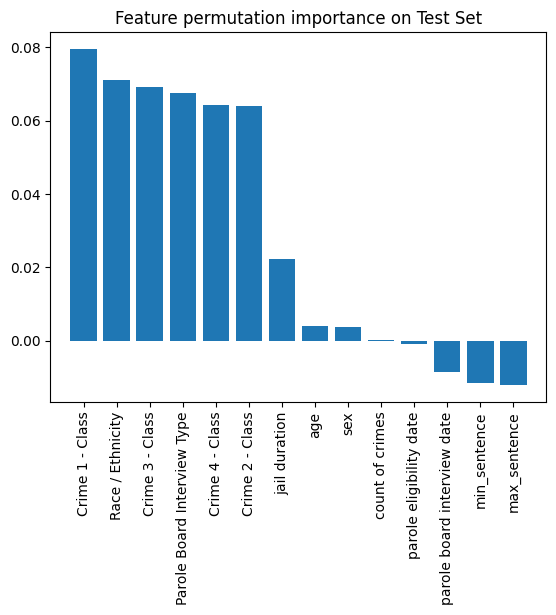

In [25]:
feature_names = [
    'parole board interview date', 'parole eligibility date',
       'min_sentence', 'max_sentence', 'count of crimes', 'age',
       'jail duration', 'sex',
    'Race / Ethnicity',
    'Crime 1 - Class',
    'Crime 2 - Class',
    'Crime 3 - Class',
    'Crime 4 - Class',
    'Parole Board Interview Type'
]

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.bar(range(len(feature_names)), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(len(feature_names)),
           np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, len(feature_names)])
plt.title('Feature permutation importance on Test Set')
plt.show()

##### Train set

In [30]:
# Ensure that the data is in the correct format (NumPy arrays)
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

In [31]:
feature_group = [0, 1, 2, 3, 4, 5, 6, 7, range(8, 15), range(15, 20),   # Crime 1 - Class (columns 15-19)
    range(20, 25),   # Crime 2 - Class (columns 20-24)
    range(25, 30),   # Crime 3 - Class (columns 25-29)
    range(30, 35),   # Crime 4 - Class (columns 30-34)
    range(35, 38)]


imp_vals, imp_all = feature_importance_permutation(
    predict_method=model_xgb.predict, 
    X=X_train,
    y=y_train,
    metric='accuracy',
    num_rounds=1,
    seed=1,
    feature_groups=feature_group)

imp_vals

array([-0.00573215,  0.00156331, -0.00658487, -0.00909565,  0.00402672,
        0.01321711,  0.03102942,  0.00350561,  0.0829504 ,  0.08759297,
        0.08133971,  0.08432422,  0.08602966,  0.08726136])

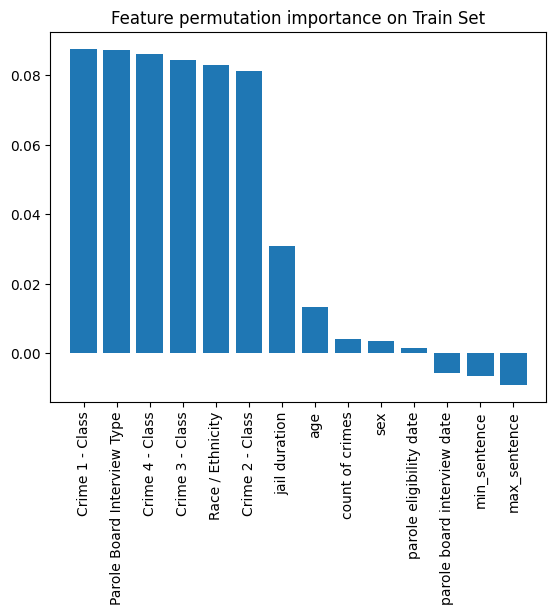

In [32]:
feature_names = [
    'parole board interview date', 'parole eligibility date',
       'min_sentence', 'max_sentence', 'count of crimes', 'age',
       'jail duration', 'sex',
    'Race / Ethnicity',
    'Crime 1 - Class',
    'Crime 2 - Class',
    'Crime 3 - Class',
    'Crime 4 - Class',
    'Parole Board Interview Type'
]

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.bar(range(len(feature_names)), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(len(feature_names)),
           np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, len(feature_names)])
plt.title('Feature permutation importance on Train Set')
plt.show()

### Second try

#### On test data

In [15]:
result = permutation_importance(
    model_xgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

<Figure size 1000x500 with 0 Axes>

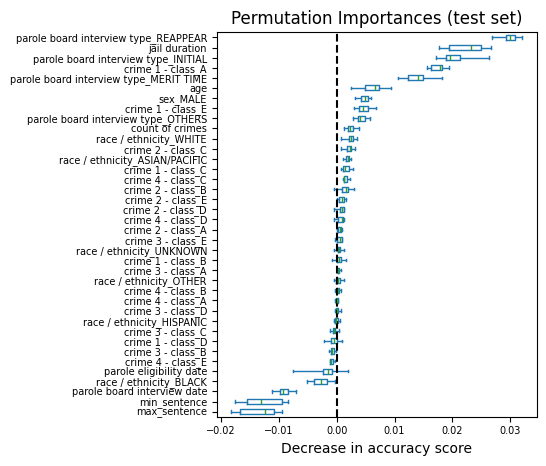

In [23]:
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)

fig = plt.figure(figsize=(10, 5))

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

plt.xticks(fontsize=7)
plt.yticks(fontsize=7);

#### On train data

In [24]:
result = permutation_importance(
    model_xgb, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

<Figure size 1000x500 with 0 Axes>

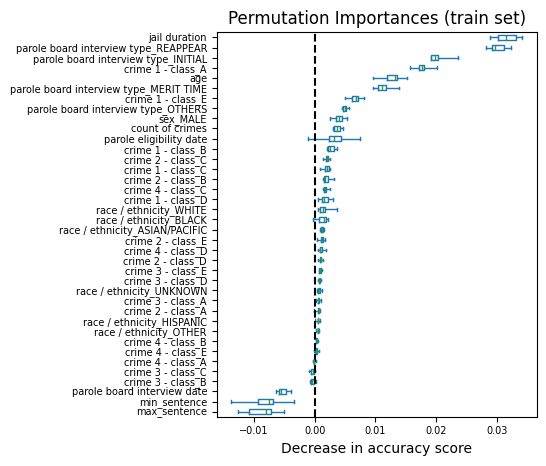

In [25]:
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)

fig = plt.figure(figsize=(10, 5))

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

plt.xticks(fontsize=7)  # Adjust the fontsize as needed
plt.yticks(fontsize=7);

## XPER

In [1]:
import XPER

In [8]:
from XPER.compute.Performance import ModelPerformance

# Define the evaluation metric(s) to be used
XPER = ModelPerformance(X_train, y_train, X_test, y_test, model_xgb)

# Evaluate the model performance using the specified metric(s)
PM = XPER.evaluate(["AUC"])

# Print the performance metrics
print("Performance Metrics: ", round(PM, 3))

Performance Metrics:  0.755


In [12]:
# Option 1 - Kernel True
# Calculate XPER values for the model's performance
XPER_values = XPER.calculate_XPER_values(["AUC"], )

Performing Computation:   0%|          | 0/1 [02:43<?, ?it/s]


MemoryError: 